A full matching of localities names has been made as follow :

For each locality in the RENALOC list :
1. The name of the locality is encoded using the double Metaphone algorithm
2. For each voting bureau in the same Commune as the locality :
    1. The name of the bureau is encoded using the double Metaphone algorithm
    2. The Jaro Distance between the locality name and the bureau name is computed
    3. The Levenshtein Distance between the locality name and the bureau name is computed
    4. The names of the locality and of the bureau are cleaned from brackets and roman numbers, and names are again encoded using double Metaphone, and Jaro and Levenshtein Distance are computed
    
A first matching strategy has been made by Fahad, using a limited labelled training set. Three steps of matching have been defined :

* __Match 1__ : The double metaphone encodings are identical and the Jaro distance is higher than 0.88
* __Match 2__ : The double metaphone encodings are identical, the Jaro distance is higher than 0.8399 and the Levenshtein distance is lower than 4
* __Match 3__ : The cleaned metaphone encodings are identical and the cleaned Jaro distance is higher than 0.88

The result of this matching procedure has been exported in csv, and the objective of this notebook is to explore these results to design a validation strategy


In [163]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LogNorm

%matplotlib inline

full_matching = pd.read_csv('renaloc_bureau_full.csv')

full_matching = full_matching.set_index(['commune_ID' , 'localite_ID' , 'localite_1'])

full_matching.loc[(full_matching.metaphone_1_clean == full_matching.metaphone_2_clean) & (full_matching.jaro_dist_clean > 0.88) , 'match_type'] = 'match_3'
full_matching.loc[(full_matching.metaphone_1 == full_matching.metaphone_2) & (full_matching.jaro_dist > 0.8399) & (full_matching.levenshtein_dist < 4) , 'match_type'] = 'match_2'
full_matching.loc[(full_matching.metaphone_1 == full_matching.metaphone_2) & (full_matching.jaro_dist > 0.88) , 'match_type'] = 'match_1'

First, we want to look at the domain in which we are working. The first figure displays the distribution of the different measures from each tested pair of names. The first column displays the matching performed on the raw names in both data sources. The second column displays the matching performed on the cleaned names. The first observation we can make is the displacement towards the right of the Jaro Similarity metric between the raw and the cleaned names. This shows the cleaning has a positive impact as it allows a greater similarity between names. 

A second remark is the existence of a distinct pole of pairs with 0 Jaro similarity, meaning they do not share any character. We can see this pole gets even bigger after cleaning, showing the cleaner allows for a reduction of variance in our comparison.

Comparing the pairs that have identical double metaphone patterns and those that don't, we can see different shapes. The mass of the pairs with similar DM patterns is in the the lower right corner, meaning greatest similarity, whereas the mass for the pairs with different patterns are in the middle of the plot, showing randomness in the similarity.

Finally, we see discontinuities in the densities we display. This may be due to the way the metrics are computed and plotted, but may also display some aspects of our data. 

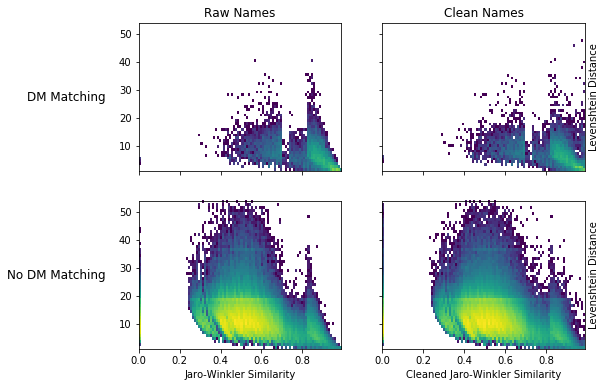

In [191]:
dm_match = full_matching[(full_matching.metaphone_1 == full_matching.metaphone_2)]
dm_no_match = full_matching[~(full_matching.metaphone_1 == full_matching.metaphone_2)]

dm_match_clean = full_matching[(full_matching.metaphone_1_clean == full_matching.metaphone_2_clean)]
dm_no_match_clean = full_matching[~(full_matching.metaphone_1_clean == full_matching.metaphone_2_clean)]

xlim = [0,1]

f, axarr = plt.subplots(2,2, sharex=True , sharey = True , figsize=(8, 6))
axarr[0,0].hist2d(dm_match.jaro_dist , dm_match.levenshtein_dist , bins=[100,40] , normed = True , norm=LogNorm())
axarr[0,0].set_title('Raw Names')
axarr[0,0].annotate('DM Matching', xy=(0, 0.5), xytext=(-axarr[0,0].yaxis.labelpad - 5 , 0),
                xycoords=axarr[0,0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
axarr[1,0].hist2d(dm_no_match.jaro_dist , dm_no_match.levenshtein_dist , bins=[100,50] , normed = True , norm=LogNorm())
axarr[1,0].annotate('No DM Matching', xy=(0, 0.5), xytext=(-axarr[1,0].yaxis.labelpad - 5 , 0),
                xycoords=axarr[1,0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')


axarr[0,1].hist2d(dm_match_clean.jaro_dist_clean , dm_match_clean.levenshtein_dist , bins=[100,50] , normed = True , norm=LogNorm())
axarr[0,1].set_title('Clean Names')
axarr[1,1].hist2d(dm_no_match_clean.jaro_dist_clean , dm_no_match_clean.levenshtein_dist , bins=[100,50] , normed = True , norm=LogNorm())


axarr[0,1].set_ylabel('Levenshtein Distance')
axarr[0,1].yaxis.set_label_position("right")

axarr[1,1].set_ylabel('Levenshtein Distance')
axarr[1,1].yaxis.set_label_position("right")


axarr[1,0].set_xlabel('Jaro-Winkler Similarity')
axarr[1,1].set_xlabel('Cleaned Jaro-Winkler Similarity')

plt.show()

In a second step, we see where the automatic matches have been made. We take out the second matches as they are defined on a very reduced support. We see that the third match using clean names allows to extend the matching in a zone that is out of the first matching. Meanwhile, we also see most of the first matches are perfect matches, with Levenshtein distances consistently under 2. 

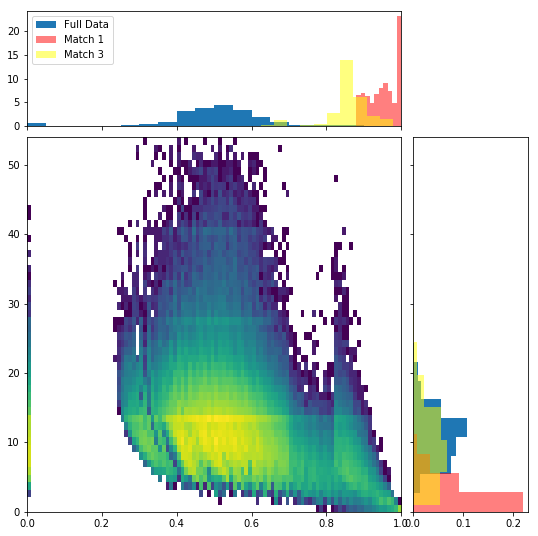

In [190]:
# the random data
x = list(full_matching.jaro_dist)
y = list(full_matching.levenshtein_dist)

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.hist2d(x, y , bins = [100 , 50] , norm=LogNorm())

# now determine nice limits by hand:
binwidth = 0.25
ymax = np.max([1, np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((0, 1))
axScatter.set_ylim((0, ymax))

axHistx.hist(x , bins = 20 , label='Full Data' , normed = True)#, bins=bins)
axHisty.hist(y, orientation='horizontal' , bins = 20   , normed = True)#, bins=bins

axHistx.hist(list(full_matching.jaro_dist[full_matching.matched  & (full_matching.match_type == 'match_1')])  , color = 'red' , label='Match 1' , normed = True , alpha = .5)
axHisty.hist(list(full_matching.levenshtein_dist[full_matching.matched & (full_matching.match_type == 'match_1')]), orientation='horizontal' ,  color = 'red' , normed = True , alpha = .5)

axHistx.hist(list(full_matching.jaro_dist[full_matching.matched  & (full_matching.match_type == 'match_3')])  , color = 'yellow' , label='Match 3' , normed = True , alpha = .5)
axHisty.hist(list(full_matching.levenshtein_dist[full_matching.matched & (full_matching.match_type == 'match_3')]), orientation='horizontal' ,  color = 'yellow' , normed = True , alpha = .5)

axHistx.legend()
axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()